## Загрузка библиотек

In [1]:
import os

import random
import pandas as pd
import numpy as np
from tqdm import tqdm

import matplotlib
import plotly
import PIL
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

## Загрузка датасета

Также посмотрим количество изображений в датасете и часть из них визуализируем





In [2]:
!git clone 'https://github.com/MelnikDM/SVO.git'

Cloning into 'SVO'...
remote: Enumerating objects: 3854, done.
remote: Counting objects: 100% (320/320), done.
remote: Compressing objects: 100% (292/292), done.
remote: Total 3854 (delta 27), reused 305 (delta 17), pack-reused 3534
Receiving objects: 100% (3854/3854), 547.96 MiB | 36.07 MiB/s, done.
Resolving deltas: 100% (1770/1770), done.
Updating files: 100% (3570/3570), done.


In [3]:
images_path = '/content/SVO/LA_ObjectDetection/data/Images'

In [4]:
images_count = np.array(os.listdir('/content/SVO/LA_ObjectDetection/data/Images'))
print(f'Количество изображений в датасете: {images_count.shape[0]}')

Количество изображений в датасете: 1655


In [5]:
def display_multiple_img(images: np.ndarray, images_path: str, cols: int = 2):

    """ Функция для визуализации фотографий """

    assert (images.shape[0] % cols) == 0

    for imagename_pair in images.reshape(-1, cols):
        _, axs = plt.subplots(nrows = 1, ncols = cols, figsize = (10, 10))

        for ind, imagename in enumerate(imagename_pair):
            image = cv2.imread(
                os.path.join(images_path, imagename)
            )
            axs[ind].imshow(image[:,:,::-1])
            axs[ind].axis('off')

In [6]:
images_indices = np.arange(images_count.shape[0], dtype='int')
np.random.shuffle(images_indices)

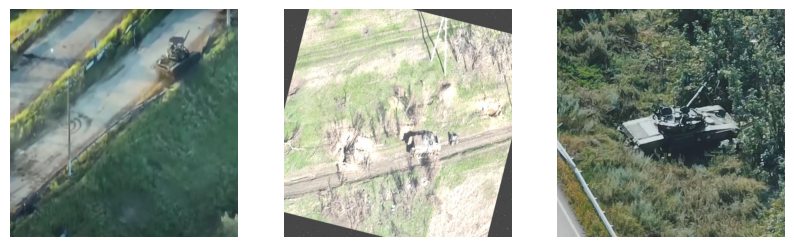

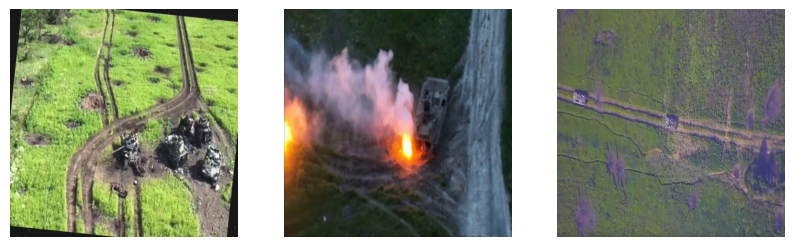

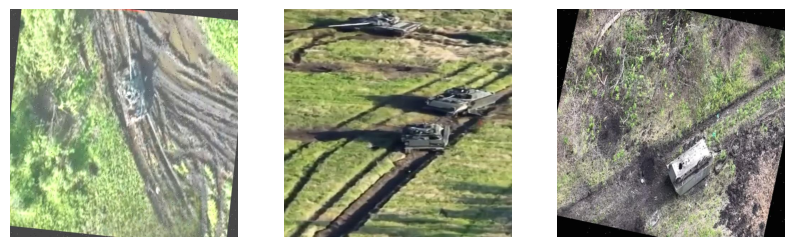

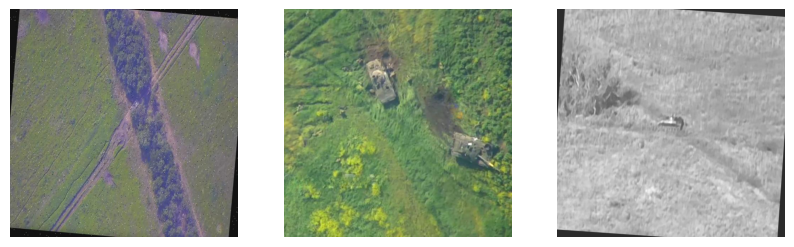

In [7]:
k = 12
first_k_images = images_count[images_indices][:k]

display_multiple_img(
    images=first_k_images,
    images_path=images_path,
    cols=3
)

In [ ]:
# Размеры изображений изменены на 640х640 => aspect ratio будет равен 1.

# def get_images_metainfo(images_list: np.ndarray, images_path: str):

#     """
#        Данная функция собирает метаданные изображения
#        Результат функции это список словарей: imagename,
#        width, height, aspect_ratio
#     """

#     metainfo = []

#     for imagename in tqdm(images_list, total = images_list.shape[0]):
#         current_meta = {
#             'imagename': imagename,
#         }

#         image_path = os.path.join(images_path, imagename)
#         width, height, channels = cv2.imread(image_path).shape

#         current_meta['width'] = width
#         current_meta['height'] = height
#         current_meta['aspect_ratio'] = width/height
#         metainfo.append(current_meta)

#     return metainfo

Теперь попробуем построить heatmap с нашими баундинг боксами. Для начала "раздраконим" наш xml и сделаем из него датафрейм pandas

In [8]:
input_folder = r"/content/SVO/LA_ObjectDetection/data/Annotations"

# cols = ['name', 'xmin', 'ymin', 'xmax', 'ymax']

def merge_files(input_folder):
    global df2
    xml_list = []
    for file in os.listdir(input_folder):
        df = pd.read_xml(f"{input_folder}/{file}", iterparse={"object": ["name", "xmin", "ymin", "xmax", "ymax"]})
        xml_list.append(df)

    pd.set_option('display.max_columns', None)
    xml_merged = pd.concat(xml_list, ignore_index=True)
    df2 = pd.DataFrame(xml_merged)
    return df2


merge_files(input_folder)

,name,xmin,xmax,ymin,ymax
0,MBT,262,329,296,348
1,MBT,319,357,312,380
2,MBT,207,321,217,395
3,APC,266,424,321,421
4,AIFV,153,324,436,589
...,...,...,...,...,...
2869,AIFV,466,503,336,366
2870,AIFV,423,457,280,303
2871,MBT,491,525,436,467
2872,AIFV,248,326,275,369


Попутно взглянем, как распределились наши классы

In [9]:
df2.name.value_counts()

MBT          1118
AIFV         1010
APC           265
Vehicle       250
Destroyed     231
Name: name, dtype: int64

In [10]:
fig = px.bar(df2.name.value_counts().sort_index(),
             color=df2.name.value_counts().sort_index().index, opacity=0.85,
             log_y=True,
             labels={"y":"Количество аннотаций на класс", "x":""},
             title="<b>Количество аннотаций на класс</b>",)
fig.update_layout(legend_title=None,
                  xaxis_title="",
                  yaxis_title="<b>Количество аннотаций на класс</b>")

fig.show()

In [11]:
def create_fractional_bbox_coordinates(row):
    """ Данная функция вычисляет долю площади ограничивающего прямоугольника """
    img_width = 640
    img_height = 640
    frac_x_min = row["xmin"]/img_width
    frac_x_max = row["xmax"]/img_width
    frac_y_min = row["ymin"]/img_height
    frac_y_max = row["ymax"]/img_height
    return frac_x_min, frac_x_max, frac_y_min, frac_y_max

In [12]:
df2["frac_x_min"], df2["frac_x_max"], df2["frac_y_min"], df2["frac_y_max"] = \
    zip(*df2.apply(create_fractional_bbox_coordinates, axis=1))

In [13]:
df2

,name,xmin,xmax,ymin,ymax,frac_x_min,frac_x_max,frac_y_min,frac_y_max
0,MBT,262,329,296,348,0.409375,0.514062,0.462500,0.543750
1,MBT,319,357,312,380,0.498437,0.557813,0.487500,0.593750
2,MBT,207,321,217,395,0.323437,0.501563,0.339062,0.617188
3,APC,266,424,321,421,0.415625,0.662500,0.501563,0.657813
4,AIFV,153,324,436,589,0.239063,0.506250,0.681250,0.920312
...,...,...,...,...,...,...,...,...,...
2869,AIFV,466,503,336,366,0.728125,0.785937,0.525000,0.571875
2870,AIFV,423,457,280,303,0.660937,0.714063,0.437500,0.473438
2871,MBT,491,525,436,467,0.767188,0.820312,0.681250,0.729688
2872,AIFV,248,326,275,369,0.387500,0.509375,0.429688,0.576562


Создадим столбец **classes**, в который закодируем в виде номера метку. А затем сгенерируем словарь **class_id**, который позволит нам перевести числовые метки обратно в их соответствующие строковые представления.

In [14]:
classes = {'MBT':0, 'AIFV':1, 'APC':2, 'Destroyed':3, 'Vehicle':4}

df2['classes'] = df2['name'].map(classes)

In [16]:
class_id = {i:df2[df2["classes"]==i].iloc[0]["name"] for i in range(5)}

100%|██████████| 2874/2874 [00:00<00:00, 6719.26it/s]


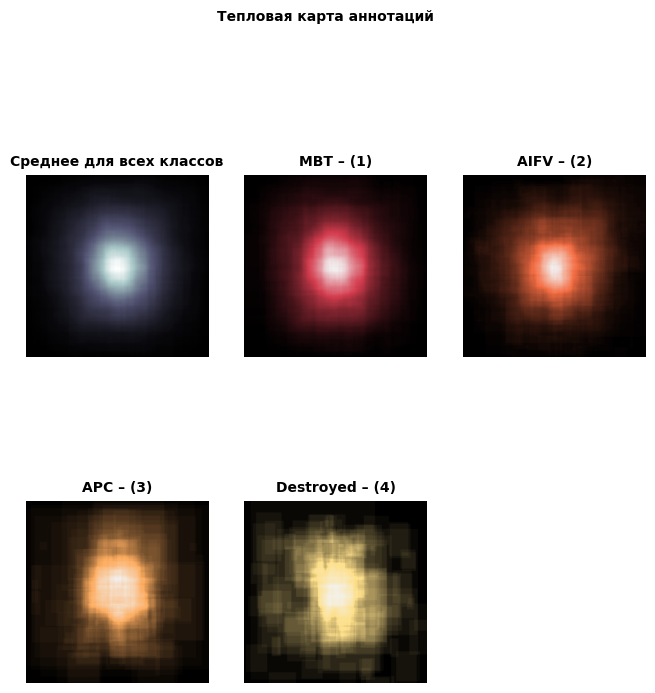

In [18]:
HEATMAP_SIZE = (640, 640, 5)

heatmap = np.zeros((HEATMAP_SIZE), dtype=np.int16)
bbox_np = df2[["classes", "frac_x_min", "frac_x_max", "frac_y_min", "frac_y_max"]].to_numpy()
bbox_np[:, 1:3] *= 640
bbox_np[:, 3:5] *= 640
bbox_np = np.floor(bbox_np).astype(np.int16)

custom_cmaps = [
    matplotlib.colors.LinearSegmentedColormap.from_list(
        colors=[(0.,0.,0.), c, (0.95,0.95,0.95)],
        name=f"custom_{i}") for i,c in enumerate(sns.color_palette("Spectral", 9))
]
custom_cmaps.pop(8)

for row in tqdm(bbox_np, total=bbox_np.shape[0]):
    heatmap[row[3]:row[4]+1, row[1]:row[2]+1, row[0]] += 1

fig = plt.figure(figsize=(8,12))
plt.suptitle("Тепловая карта аннотаций", fontweight="bold", fontsize=10)
for i in range(5):
    plt.subplot(3, 3, i+1)
    if i==0:
        plt.imshow(heatmap.mean(axis=-1), cmap="bone")
        plt.title(f"Среднее для всех классов", fontweight="bold", fontsize=10)
    else:
        plt.imshow(heatmap[:, :, i-1], cmap=custom_cmaps[i-1])
        plt.title(f"{class_id[i-1]} – ({i})", fontweight="bold", fontsize=10)

    plt.axis(False)
plt.show()

В общем, можно было и не строить тепловую карту, так как для данной задачи она совершенно неинформативна.